<a href="https://colab.research.google.com/github/fAikoH-dot/TCC-v1/blob/main/arima/auto_arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd

In [3]:
# df = pd.read_csv("sample_data/Trigo_v1.csv", sep = ";")
df = pd.read_csv('../../data library/Trigo_v1.csv', sep=";")
df = df.sort_values(by='Data').reset_index(drop=True)
# df.set_index("Data", inplace = True)
df.head()

,Data,Cultivo,Estadual,País,Id,Último,Abertura,Máxima,Mínima
0,2004-03-01,Trigo,25.0014,24.2907,2,NaN,NaN,NaN,NaN
1,2004-04-01,Trigo,27.3438,26.4508,2,NaN,NaN,NaN,NaN
2,2004-05-01,Trigo,29.6849,28.6268,2,NaN,NaN,NaN,NaN
3,2004-06-01,Trigo,30.2614,29.9106,2,NaN,NaN,NaN,NaN
4,2004-07-01,Trigo,27.5388,27.7931,2,NaN,NaN,NaN,NaN


In [4]:
%pip install python-bcb

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
from bcb import PTAX
from bcb import currency

ptax = PTAX()

df_usd = currency.get(['USD'],
                  start='2004-03-01',
                  end='2024-09-01',
                  side='ask')

df_usd["Date"]=df_usd.index
df_usd["Month"] = df_usd["Date"].dt.month
df_usd["Year"] = df_usd["Date"].dt.year
df_usd["Day"] = 1
df_usd["Aux"] = df_usd["Year"].astype(str) +"-"+ df_usd["Month"].astype(str)
df_usd = df_usd.groupby("Aux").agg(
    USD = ("USD", "mean"),
    day = ("Day", "first"),
    month = ("Month", "first"),
    year = ("Year", "first"),
).reset_index(drop=True)

df_usd["Data"] = pd.to_datetime(df_usd[['year', 'month', 'day']])
df_usd = df_usd[["Data", "USD"]].sort_values(by="Data").reset_index(drop=True)

In [7]:
# clima = pd.read_csv("sample_data/MT_dados.csv", sep=';')
clima = pd.read_csv("../../data library/Clima/MT_dados.csv", sep=';')
clima.rename(columns={"PRECIPITACAO TOTAL":"precipitacao", "TEMPERATURA MEDIA":"temperatura"}, inplace=True)

clima["precipitacao"] = clima.precipitacao.str.replace(',', '.')
clima["temperatura"] = clima.temperatura.str.replace(',', '.')

clima.bfill(inplace=True)
clima.head()

,Data Medicao,precipitacao,temperatura
0,31/03/2004,175.4,24.9
1,30/04/2004,175.4,24.5
2,31/05/2004,23,21.7
3,30/06/2004,18.8,22.1
4,31/07/2004,38,22.2


In [8]:
df["USD"] = df_usd["USD"]
df["Precipitacao"] = clima["precipitacao"].astype(float)
df["Temperatura"] = clima["temperatura"].astype(float)
df['lag_Estadual'] = df['Estadual'].shift(1)
df['lag_Estadual'] = df['lag_Estadual'].bfill()
df.head()

,Data,Cultivo,Estadual,País,Id,Último,Abertura,Máxima,Mínima,USD,Precipitacao,Temperatura,lag_Estadual
0,2004-03-01,Trigo,25.0014,24.2907,2,NaN,NaN,NaN,NaN,2.905457,175.4,24.9,25.0014
1,2004-04-01,Trigo,27.3438,26.4508,2,NaN,NaN,NaN,NaN,2.905985,175.4,24.5,25.0014
2,2004-05-01,Trigo,29.6849,28.6268,2,NaN,NaN,NaN,NaN,3.100419,23.0,21.7,27.3438
3,2004-06-01,Trigo,30.2614,29.9106,2,NaN,NaN,NaN,NaN,3.129148,18.8,22.1,29.6849
4,2004-07-01,Trigo,27.5388,27.7931,2,NaN,NaN,NaN,NaN,3.036777,38.0,22.2,30.2614


In [9]:
%pip install pmdarima

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

from pmdarima.arima import auto_arima
from pmdarima import arima
from pmdarima.utils import tsdisplay, autocorr_plot, decomposed_plot, plot_acf, plot_pacf
from matplotlib.pyplot import rcParams

rcParams['figure.figsize']=15,6

from pmdarima.arima import ADFTest
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [11]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error

In [12]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, signif=0.05, name='', verbose=False):


    result = adfuller(series.values)
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

def plot_predictions(testing_dates, y_test, prediction):
    df_test = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": prediction })
    _, ax = plt.subplots(figsize=(10, 5))
    df_test.plot(ax=ax, label="Actual", x="date", y="actual")
    df_test.plot(ax=ax, label="Prediction", x="date", y="prediction")
    plt.legend(["Actual", "Prediction"])
    plt.show()

In [13]:
def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"RMSE: {root_mean_squared_error(y_test, prediction)}")
  print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")
  print(f"R-Squared: {r2_score(y_test, prediction)}")

In [14]:
train_size = int(len(df) * 0.8)
train, test = df[0:train_size], df[train_size:len(df)]

check_stationarity(train["Estadual"], name=train["Estadual"].name)

    Augmented Dickey-Fuller Test on "Estadual" 
    -----------------------------------------------
ADF Statistic: 0.243385
p-value: 0.974593
Critical Values:
	1%: -3.464
	5%: -2.876
	10%: -2.575
Non-stationary


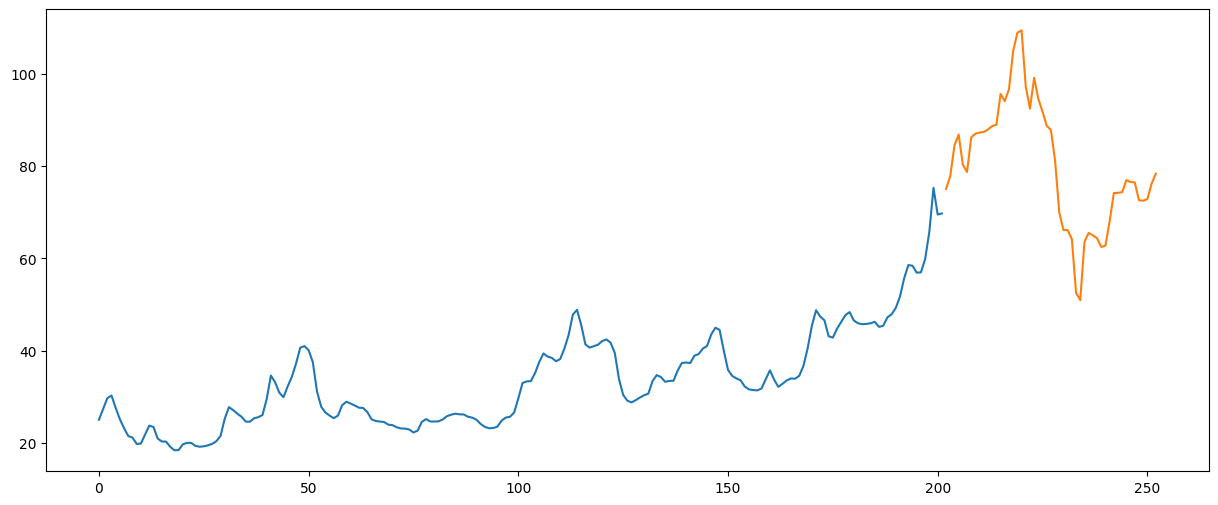

In [15]:
train_size = int(len(df) * 0.8)
train, test = df[0:train_size], df[train_size:len(df)]

test_dates = test.Data

# train = train.Estadual
# test = test.Estadual

plt.plot(train.Estadual)
plt.plot(test.Estadual)

In [16]:
from pmdarima.arima import ADFTest

adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(df["Estadual"])

##Dado Não-Estacionário > I = 0

(0.36881524732892557, True)

In [17]:
train.head()

,Data,Cultivo,Estadual,País,Id,Último,Abertura,Máxima,Mínima,USD,Precipitacao,Temperatura,lag_Estadual
0,2004-03-01,Trigo,25.0014,24.2907,2,NaN,NaN,NaN,NaN,2.905457,175.4,24.9,25.0014
1,2004-04-01,Trigo,27.3438,26.4508,2,NaN,NaN,NaN,NaN,2.905985,175.4,24.5,25.0014
2,2004-05-01,Trigo,29.6849,28.6268,2,NaN,NaN,NaN,NaN,3.100419,23.0,21.7,27.3438
3,2004-06-01,Trigo,30.2614,29.9106,2,NaN,NaN,NaN,NaN,3.129148,18.8,22.1,29.6849
4,2004-07-01,Trigo,27.5388,27.7931,2,NaN,NaN,NaN,NaN,3.036777,38.0,22.2,30.2614


# USD

In [18]:
train_size = int(len(df) * 0.8)
train, test = df[0:train_size], df[train_size:len(df)]

test_dates = test.Data

In [19]:
arima_model = auto_arima(train.Estadual, X = train[["USD", "País"]],start_p=0, d=0, start_q=0,
                         max_p = 5, max_d = 5, max_q = 5,
                         start_P = 0, D = 0, start_Q=5,
                         max_P=5, max_D=5, max_Q=5,
                         m=12, seasonal=True, error_action ="warn",
                         Trace=True, random_state=20, n_fits=50)

In [20]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  202
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -317.335
Date:                Mon, 07 Apr 2025   AIC                            644.669
Time:                        00:23:28   BIC                            661.211
Sample:                             0   HQIC                           651.362
                                - 202                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3281      0.159      2.058      0.040       0.016       0.641
USD            2.0775      0.611      3.400      0.001       0.880       3.275
País           0.7635      0.030     25.245      0.000       0.704       0.823
ar.L1          0.9128      0.016     56.534      0.000       0.881       0.944
sigma2         1.3434      0.096     13.990      0.000       1.155       1.532
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2789.04
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                            -0.89
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
prediction = pd.DataFrame(arima_model.predict(n_periods=len(test), X=test[["USD", "País"]]),
                          # index=test.index
                          )
prediction.columns = ["predicted_Estadual"]
prediction.index = test.index

ValueError: Found non-finite values in dataframe

<ipython-input-23-c44d8dde0550>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Data"] = test.index


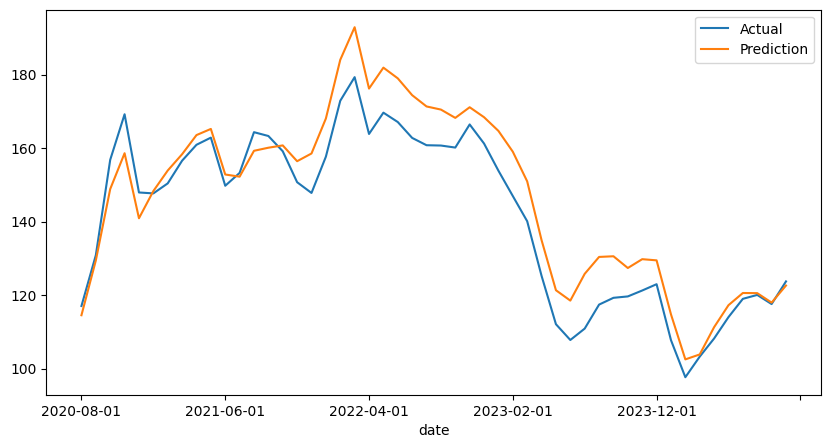

In [ ]:
test["Data"] = test.index
testing_dates = test_dates

plot_predictions(testing_dates, test.Estadual, prediction.predicted_Estadual)

In [ ]:
test = pd.DataFrame(test)
test["predict_Estadual"] = prediction['predicted_Estadual']
test.head()

,Data,Cultivo,Estadual,País,Id,Último,Abertura,Máxima,Mínima,USD,Precipitacao,Temperatura,lag_Estadual,predict_Estadual
196,196,Soja,117.0222,113.3375,0,95250.00000,89175.00000,96688.00000,86538.00000,5.280191,33.0,26.7,104.0607,114.511640
197,197,Soja,130.8449,128.3004,0,1.02175,95062.00000,1.04650,94288.00000,5.461233,33.0,26.7,117.0222,129.417034
198,198,Soja,156.7972,147.4121,0,1.05688,1.02338,1.09388,1.01300,5.399486,33.0,26.7,130.8449,148.846007
199,199,Soja,169.1946,157.3982,0,1.16875,1.06025,1.19962,1.04162,5.625790,33.0,26.7,156.7972,158.592977
200,200,Soja,147.9145,140.9301,0,1.31025,1.16962,1.32060,1.14262,5.417835,33.0,26.7,169.1946,140.897886


In [ ]:
evaluate_model(test["Estadual"], test["predict_Estadual"])

MAE: 6.839740734014266
RMSE: 8.079860711872838
MAPE: 0.048617990048654025
R-Squared: 0.8728950563109299


# Multiple Variables

In [ ]:
train_size = int(len(df) * 0.8)
train, test = df[0:train_size], df[train_size:len(df)]

test_dates = test.Data

In [ ]:
arima_model = auto_arima(train.Estadual, X = train[["USD", "País", "Último", "Máxima", "Precipitacao", "lag_Estadual"]],start_p=0, d=0, start_q=0,
                         max_p = 5, max_d = 5, max_q = 5,
                         start_P = 0, D = 0, start_Q=5,
                         max_P=5, max_D=5, max_Q=5,
                         m=12, seasonal=True, error_action ="warn",
                         Trace=True, random_state=20, n_fits=50)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


In [22]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  202
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -317.335
Date:                Mon, 07 Apr 2025   AIC                            644.669
Time:                        00:23:31   BIC                            661.211
Sample:                             0   HQIC                           651.362
                                - 202                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3281      0.159      2.058      0.040       0.016       0.641
USD            2.0775      0.611      3.400      0.001       0.880       3.275
País           0.7635      0.030     25.245      0.000       0.704       0.823
ar.L1          0.9128      0.016     56.534      0.000       0.881       0.944
sigma2         1.3434      0.096     13.990      0.000       1.155       1.532
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2789.04
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                            -0.89
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
# Import required libraries

import pandas as pd
import numpy as np

# Create dataframe using dictionary
data_aux = test.copy()

df_aux = pd.DataFrame(data_aux)

# Replace infinite updated data with nan
df_aux.replace([np.inf, -np.inf], np.nan, inplace=True)

df_aux.ffill(inplace=True)

test = df_aux.copy()

In [28]:
prediction = pd.DataFrame(arima_model.predict(n_periods=len(test), X=test[["USD", "País", "Último", "Máxima", "Precipitacao", "lag_Estadual"]]),
                          # index=test.index
                          )
prediction.columns = ["predicted_Estadual"]
prediction.index = test.index

ValueError: Provided exogenous values are not of the appropriate shape. Required (51, 2), got (51, 6).

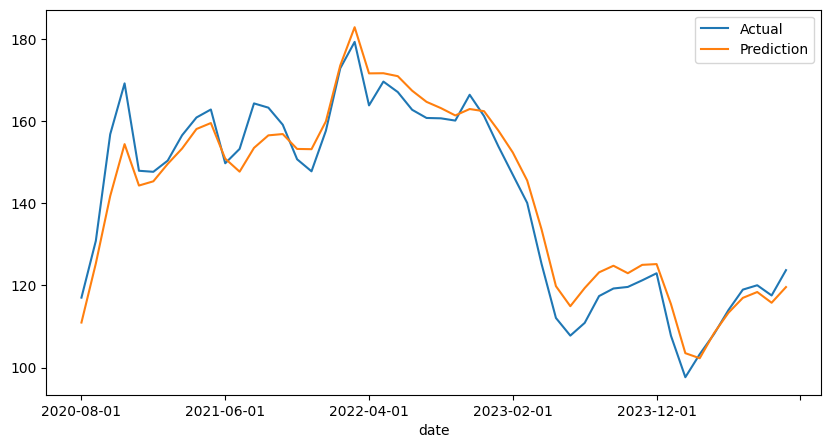

In [40]:
test["Data"] = test.index
testing_dates = test_dates

plot_predictions(testing_dates, test.Estadual, prediction.predicted_Estadual)

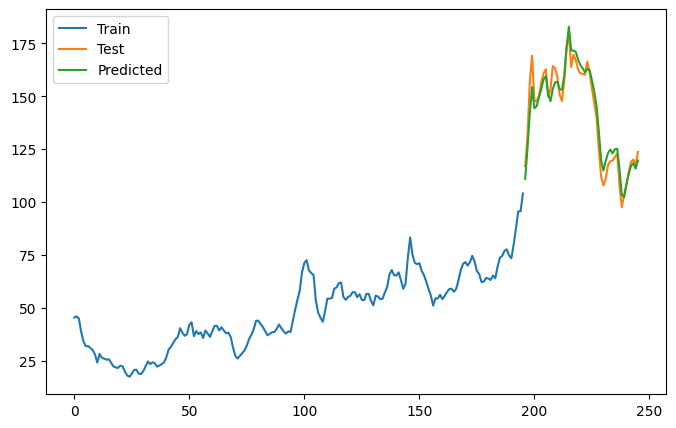

In [41]:
plt.figure(figsize=(8,5))
plt.plot(train.Estadual, label = "Train")
plt.plot(test.Estadual, label = "Test")
plt.plot(prediction, label = "Predicted")
plt.legend(loc='upper left')
plt.show()

In [42]:
test = pd.DataFrame(test)
test["predict_Estadual"] = prediction['predicted_Estadual']
test.head()

,Data,Cultivo,Estadual,País,Id,Último,Abertura,Máxima,Mínima,USD,Precipitacao,Temperatura,lag_Estadual,predict_Estadual
196,196,Soja,117.0222,113.3375,0,95250.00000,89175.00000,96688.00000,86538.00000,5.280191,33.0,26.7,104.0607,110.955738
197,197,Soja,130.8449,128.3004,0,1.02175,95062.00000,1.04650,94288.00000,5.461233,33.0,26.7,117.0222,125.333324
198,198,Soja,156.7972,147.4121,0,1.05688,1.02338,1.09388,1.01300,5.399486,33.0,26.7,130.8449,141.760589
199,199,Soja,169.1946,157.3982,0,1.16875,1.06025,1.19962,1.04162,5.625790,33.0,26.7,156.7972,154.398191
200,200,Soja,147.9145,140.9301,0,1.31025,1.16962,1.32060,1.14262,5.417835,33.0,26.7,169.1946,144.315342


In [43]:
evaluate_model(test["Estadual"], test["predict_Estadual"])

MAE: 4.424606110083662
RMSE: 5.47067492606383
MAPE: 0.03210967260751286
R-Squared: 0.9417311411382636


Não-estacionário para Estacionário


In [ ]:
teste = pd.Series(df["Estadual"], name="Estadual")
teste.describe()

,Estadual
count,246.000000
mean,67.186526
std,42.222066
min,17.383800
25%,37.853025
50%,55.675250
75%,74.322025
max,179.294900


In [94]:
df = pd.read_csv("sample_data/Soja_v1.csv", sep = ";")
df = df.sort_values(by='Data').reset_index(drop=True)
# df.set_index("Data", inplace = True)
df.head()

,Data,Cultivo,Estadual,País,Id,Último,Abertura,Máxima,Mínima
0,2004-03-01,Soja,45.3777,50.0455,0,1.034,1.000,1.064,92600.0
1,2004-04-01,Soja,45.9456,48.7279,0,81400.000,1.036,1.063,81200.0
2,2004-05-01,Soja,44.8723,47.4930,0,89300.000,82800.000,94000.000,0.0
3,2004-06-01,Soja,38.5913,40.7781,0,59950.000,89200.000,1.035,59900.0
4,2004-07-01,Soja,34.0818,37.5474,0,62725.000,59100.000,71200.000,56500.0


In [96]:
df['Data'] = pd.to_datetime(df['Data'])
df["USD"] = df_usd["USD"]
df = df.set_index('Data')
monthly_summary = df.Estadual.resample('ME').mean().ffill()

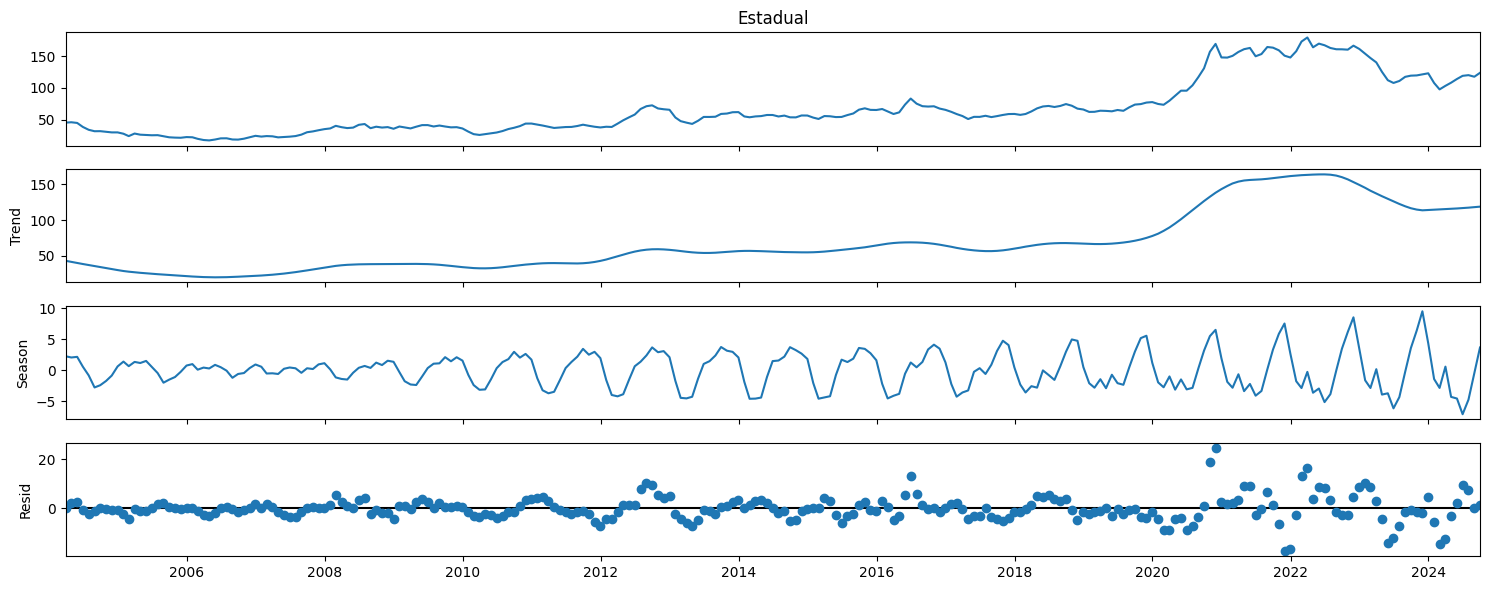

In [98]:
from statsmodels.tsa.seasonal import STL

stl = STL(monthly_summary, seasonal=13)
res = stl.fit()
fig = res.plot()

In [ ]:
#Aplicanto a função Log para converter os dados para estacionários

df_log=np.sqrt(df['Estadual'])
df_diff=df_log.diff().dropna()

In [ ]:
# from pmdarima.arima import ADFTest

# adf_test = ADFTest(alpha = 0.05)
# adf_test.should_diff(df_diff)

##Dado Estacionário > I = 1

check_stationarity(df_diff, name=df_diff.name)

    Augmented Dickey-Fuller Test on "Estadual" 
    -----------------------------------------------
ADF Statistic: -10.111737
p-value: 0.000000
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573
Stationary


In [ ]:
df["Estadual"] = df_diff
df = df.bfill()
df.head()

,Cultivo,Estadual,País,Id,Último,Abertura,Máxima,Mínima,USD
Data,,,,,,,,,
2004-03-01,Soja,0.042021,50.0455,0,1.034,1.000,1.064,92600.0,2.905457
2004-04-01,Soja,0.042021,48.7279,0,81400.000,1.036,1.063,81200.0,2.905985
2004-05-01,Soja,-0.079639,47.4930,0,89300.000,82800.000,94000.000,0.0,3.100419
2004-06-01,Soja,-0.486489,40.7781,0,59950.000,89200.000,1.035,59900.0,3.129148
2004-07-01,Soja,-0.374228,37.5474,0,62725.000,59100.000,71200.000,56500.0,3.036777


In [ ]:
train_size = int(len(df.Estadual.dropna()) * 0.75)

train, test = df[0:train_size], df[train_size:len(df)]
# train, test = df.Estadual.dropna()[0:size], df.Estadual.dropna()[size:len(df.Estadual.dropna())]
# test = test.reset_index()['Estadual']
history = [x for x in train.Estadual]
predictions = []

In [ ]:
arima_model = auto_arima(train.Estadual, X = train[["USD", "País"]], start_p=0, d=1, start_q=0,
                         max_p = 5, max_d = 5, max_q = 5,
                         start_P = 0, D = 1, start_Q=5,
                         max_P=5, max_D=5, max_Q=5,
                         m=13, seasonal=True, error_action ="warn",
                         Trace=True, random_state=20, n_fits=50)

In [ ]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  184
Model:             SARIMAX(1, 1, 1)x(5, 1, 1, 13)   Log Likelihood                  13.299
Date:                            Wed, 30 Oct 2024   AIC                             -4.598
Time:                                    00:08:19   BIC                             29.896
Sample:                                         0   HQIC                             9.399
                                            - 184                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
USD           -0.1047      0.065     -1.603      0.109      -0.233       0.023
País           0.0063      0.004      1.589      0.112      -0.001       0.014
ar.L1          0.4219      0.108      3.924      0.000       0.211       0.633
ma.L1         -0.9481      0.053    -17.827      0.000      -1.052      -0.844
ar.S.L13      -0.2865      0.242     -1.184      0.237      -0.761       0.188
ar.S.L26      -0.2669      0.195     -1.371      0.170      -0.648       0.115
ar.S.L39      -0.2279      0.182     -1.252      0.211      -0.585       0.129
ar.S.L52      -0.3005      0.156     -1.932      0.053      -0.605       0.004
ar.S.L65      -0.2485      0.144     -1.723      0.085      -0.531       0.034
ma.S.L13      -0.6950      0.263     -2.643      0.008      -1.210      -0.180
sigma2         0.0413      0.004     10.286      0.000       0.033       0.049
===================================================================================
Ljung-Box (L1) (Q):                   0.58   Jarque-Bera (JB):                32.67
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                            -0.54
Prob(H) (two-sided):                  0.85   Kurtosis:                         4.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
prediction = pd.DataFrame(arima_model.predict(n_periods=len(test), X = test[["USD", "País"]]),
                          # index=test.index
                          )
prediction.columns = ["predicted_Estadual"]
prediction.index = test.index
prediction

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,predicted_Estadual
Data,
2019-08-01,-0.011882
2019-09-01,-0.056101
2019-10-01,-0.084652
2019-11-01,0.102759
2019-12-01,0.095207
...,...
2024-05-01,0.227837
2024-06-01,0.127428
2024-07-01,0.082220


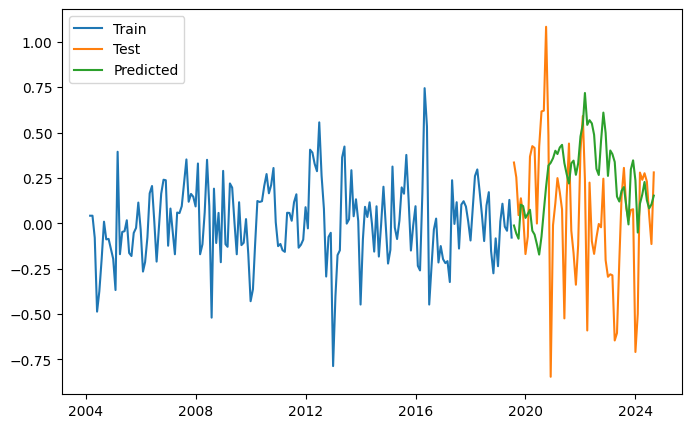

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(train.Estadual, label = "Train")
plt.plot(test.Estadual, label = "Test")
plt.plot(prediction, label = "Predicted")
plt.legend(loc='upper left')
plt.show()

In [ ]:
test = pd.DataFrame(test)
test["predict_Estadual"] = prediction['predicted_Estadual']
test

,Cultivo,Estadual,País,Id,Último,Abertura,Máxima,Mínima,USD,predict_Estadual
Data,,,,,,,,,,
2019-08-01,Soja,0.335122,71.6310,0,86825.00000,88075.00000,89662.00000,85262.00000,3.779339,-0.011882
2019-09-01,Soja,0.253732,75.7721,0,90425.00000,86638.00000,90662.00000,85112.00000,4.019982,-0.056101
2019-10-01,Soja,0.045107,76.9515,0,93175.00000,90412.00000,94538.00000,90338.00000,4.121500,-0.084652
2019-11-01,Soja,0.137983,78.0108,0,87662.00000,93100.00000,94212.00000,87612.00000,4.086987,0.102759
2019-12-01,Soja,0.042304,78.6838,0,94350.00000,87662.00000,94350.00000,86762.00000,4.155345,0.095207
...,...,...,...,...,...,...,...,...,...,...
2024-05-01,Soja,0.276085,118.2335,0,1.20350,1.16100,1.25650,1.15625,5.129095,0.227837
2024-06-01,Soja,0.230279,121.3981,0,1.15050,1.20425,1.20550,1.14625,5.133048,0.127428
2024-07-01,Soja,0.048675,121.7345,0,1.02850,1.14825,1.19150,1.02050,5.388975,0.082220


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error

In [ ]:
def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"RMSE: {root_mean_squared_error(y_test, prediction)}")
  print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")
  print(f"R-Squared: {r2_score(y_test, prediction)}")

In [ ]:
evaluate_model(test["Estadual"], test["predict_Estadual"])

MAE: 0.379506009372794
RMSE: 0.47703711657063835
MAPE: 5.539886294360534
R-Squared: -0.8047131284284901
